# Bird Audio Classification - Task 2 (Prediction)

This notebook contains tasks - Data cleaning, Spectrogram Generation, Data Augmentation, Batch Creation for CNN,  Model Building and Prediction etc.

## 1. Import Libreries

In [1]:
# !pip install tensorflow-addons==0.16.1

In [2]:
# !pip install keras_sequential_ascii
# !pip install visualkeras

In [1]:
import os
import json
import librosa 
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split 
import plotly.graph_objects as go 
from PIL import Image
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
from sklearn.utils import shuffle, class_weight
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, LSTM, SimpleRNN, Conv1D, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow_addons.metrics import F1Score

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/Users/vrunda/miniforge3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## 2. Import Data

In [84]:
# Import train_short_audio metadata that contains information about training audio files
ORIGINAL_DATA_DIR = 'birdclef-2021/train_short_audio'
SAMPLE_RATE = 22050 #sampling rate
SIGNAL_LENGTH = 10 #seconds
SPECT_SHAPE = (48, 128) # (height,width)

In [3]:
data = pd.read_csv('birdclef-2021/train_metadata.csv')
data

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62869,yetvir,[],"['adult', 'male', 'song']",30.2150,-97.6505,Vireo flavifrons,Yellow-throated Vireo,Caleb Helsel,2020-07-10,XC591680.ogg,Creative Commons Attribution-NonCommercial-Sha...,1.0,08:30,https://www.xeno-canto.org/591680
62870,yetvir,[],"['life stage uncertain', 'sex uncertain', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2019-05-31,XC600085.ogg,Creative Commons Attribution-NonCommercial-Sha...,5.0,09:30,https://www.xeno-canto.org/600085
62871,yetvir,"['amered', 'eawpew', 'norcar', 'reevir1']","['adult', 'male', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2020-06-02,XC602701.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.5,08:30,https://www.xeno-canto.org/602701
62872,yetvir,[],['uncertain'],32.2357,-99.8811,Vireo flavifrons,Yellow-throated Vireo,Brad Banner,2019-04-27,XC614733.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,17:30,https://www.xeno-canto.org/614733


In [4]:
# Select data having rating more than 3.5
data = data.query('rating>=3.5')

In [5]:
# Filter species having more than 100 training sample count
birds_count = {}
for bird_species, count in zip(data.primary_label.unique(), 
                               data.groupby('primary_label')['primary_label'].count().values):
    birds_count[bird_species] = count
birds_to_predict = [key for key,value in birds_count.items() if value >= 100] 

In [6]:
data_updated = data.loc[data.primary_label.isin(birds_to_predict)]

In [7]:
# Training data
data_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36362 entries, 3 to 62714
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     36362 non-null  object 
 1   secondary_labels  36362 non-null  object 
 2   type              36362 non-null  object 
 3   latitude          36362 non-null  float64
 4   longitude         36362 non-null  float64
 5   scientific_name   36362 non-null  object 
 6   common_name       36362 non-null  object 
 7   author            36362 non-null  object 
 8   date              36362 non-null  object 
 9   filename          36362 non-null  object 
 10  license           36362 non-null  object 
 11  rating            36362 non-null  float64
 12  time              36362 non-null  object 
 13  url               36362 non-null  object 
dtypes: float64(3), object(11)
memory usage: 4.2+ MB


In [8]:
# Example of sonspa bird
base_dir = 'birdclef-2021/train_short_audio'
data_updated['full_path'] = base_dir+ '/' + data_updated['primary_label'] + '/' + data_updated['filename']

In [9]:
sonspa = data_updated[data_updated['primary_label'] == "sonspa"].sample(1, random_state = 3)['full_path'].values[0]

In [10]:
sonspa1 = data_updated[data_updated['primary_label'] == "sonspa"].sample(1, random_state = 50)['full_path'].values[0]

In [11]:
# Play audio file
ipd.Audio(sonspa1)

## 3. Pre-processing of Audio Files, Generation of Spectrograms and Data Augmentation

#### Resample at same rate
Convert sample rate to one standard rate

In [12]:
def resample(audio):
    sig, rate = audio

    if (rate == SAMPLE_RATE):
      # Nothing to do
      return audio
    
    resample_sig = librosa.resample(sig, orig_sr = rate, target_sr = SAMPLE_RATE)
    return (resample_sig, rate)

#### Resize data to same length
All the audio files are in different size and duration. Trim or Extend length of it to 10s.

In [13]:
def resize(audio, duration):
    sig, rate = audio
    num_sample = int(duration * rate)
    if len(sig) < num_sample:
        sig_padded = np.zeros(num_sample, dtype=sig.dtype)
        sig_padded[:len(sig)] = sig
        sig = sig_padded
    else:  
        sig = sig[:num_sample]
    return (sig, rate)

#### Augment audio using time shift method
Data augmentation on the raw audio signal by applying a Time Shift to shift the audio to the left or the right by a random amount

In [14]:
def augment_audio(audio, shift_limit = 0.5):
    sig, rate = audio
    shift_samples = int(np.random.random() * shift_limit * len(sig))
    shifted_audio = np.roll(sig, shift_samples)
    
    return (shifted_audio, rate)

#### Convert audio into mel spectrogram
Create mel spectrogram of size 48x128

In [85]:
def mel_spec(audio, n_fft = 1024):
    sig, rate = audio
    
    hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPECT_SHAPE[1] - 1))

    S = librosa.feature.melspectrogram(y=sig, sr=rate, n_fft = n_fft,
                                    hop_length = hop_length, n_mels = SPECT_SHAPE[0])
    S_db_mel = librosa.power_to_db(S, ref=np.max)

    S_db_mel -= S_db_mel.min()
    S_db_mel /= S_db_mel.max()
    
    return S_db_mel

#### Mel Spectrogram Augmentation

In [86]:
def time_mask(melspec, Time=10, n_masks=1, replace_with_zero=False):
    copy_melspec = melspec.copy()
    for i in range(0, n_masks):
        t = np.random.uniform(low=0.0, high=Time)
        t = int(t)
        t_zero = np.random.randint(low=0, high=copy_melspec.shape[1] - t)
        if replace_with_zero:
            copy_melspec[:, t_zero:t_zero + t] = 0
        else:
            copy_melspec[:, t_zero:t_zero + t] = np.mean(copy_melspec)

    return copy_melspec

def freq_mask(melspec, Freq=20, n_masks=1, replace_with_zero=False):
    copy_melspec = melspec.copy()
    for i in range(0, n_masks):
        f = np.random.uniform(low=0.0, high=Freq)
        f = int(f)
        f_zero = np.random.randint(low=0, high=copy_melspec.shape[0] - f)
        if replace_with_zero:
            copy_melspec[f_zero:f_zero + f, :] = 0
        else:
            copy_melspec[f_zero:f_zero + f, :] = np.mean(copy_melspec)
    return copy_melspec

In [87]:
def spectrogram_augmentation(melspect):
    melspec_time_masked = time_mask(melspect)
    melspec_freq_masked = freq_mask(melspec_time_masked)

    return melspec_freq_masked

In [88]:
# Test methods on sample (sonspa1)
audio, rate = librosa.load(sonspa1)
resample_audio = resample((audio, rate))
resize_audio = resize(resample_audio, 10)
aug_audio = augment_audio(resize_audio, 0.5)
melspect = mel_spec(aug_audio)
aug_melspect = spectrogram_augmentation(melspect)

In [89]:
print("Shape of melspect : ", melspect.shape)
print("Shape of augmented melspect : ", aug_melspect.shape)

Shape of melspect :  (48, 128)
Shape of augmented melspect :  (48, 128)


In [20]:
# Assigned train and labels for training
TRAIN = data_updated
LABELS = sorted(data_updated.primary_label.unique())

In [21]:
def generate_spect(filepath, primary_label, output_dir, augment_dir):
    saved_samples = []
    
    sig, rate = librosa.load(filepath, sr=SAMPLE_RATE, offset=None)
    
    resample_audio = resample((sig, rate))
    resize_audio = resize(resample_audio, 10)
    aug_audio = augment_audio(resize_audio, 0.5)
    melspect = mel_spec(aug_audio)
    aug_melspect = spectrogram_augmentation(melspect)
    
    # Save spectrogram and augmented spectrogram as image
    save_dir = os.path.join(output_dir, primary_label)
    save_augment_dir = os.path.join(augment_dir, primary_label)
    
    # Create directory to save file if not exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(save_augment_dir):
        os.makedirs(save_augment_dir)
        
    # Create path to save spectrogram and augmented spectrogram
    save_path = os.path.join(save_dir, filepath.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0] + '.png')
    save_augment_path = os.path.join(save_augment_dir, filepath.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0] + '.png')
    
    im1 = Image.fromarray(melspect * 255.0).convert("L")
    im2 = Image.fromarray(aug_melspect * 255.0).convert("L")
    
    # Save to given path
    im1.save(save_path)
    im2.save(save_augment_path)
    
    # store samples to an array
    saved_samples.append({"song_sample" : save_path, "label" : primary_label})
    saved_samples.append({"song_sample" : save_augment_path, "label" : primary_label})
    
    return saved_samples

In [22]:
# Create dataframe to store generated spectrogram and augmented spectrogram path 
samples_df = pd.DataFrame(columns=["song_sample","label"])

Below commented code is to generate spectrogram. But as spectrogram images are already generated I commented the code.

In [23]:
# sample_imgs = []
# input_dir = 'birdclef-2021/train_short_audio/'
# output_dir = 'melspect_img/'
# augment_dir = 'augmented_melspect/'

In [24]:
# TRAIN_DATA = TRAIN

In [25]:
# # def audio_to_melspect(idx, row):
# with tqdm(TRAIN_DATA) as pbar:
#     for idx, row in TRAIN_DATA.iterrows():
#         pbar.update(1)
#         if row.primary_label in birds_to_predict:
#             audio_file_path = os.path.join(input_dir, row.primary_label, row.filename)
#             sample_imgs += generate_spect(audio_file_path, row.primary_label, output_dir, augment_dir)

In [26]:
# print('SUCCESSFULLY EXTRACTED {} SPECTROGRAMS'.format(len(sample_imgs)))

In [27]:
# sample_imgs = sample_imgs[:62000]

In [28]:
# num_cores = multiprocessing.cpu_count()
# print(num_cores)

In [29]:
# print(f'Starting to process {len(TRAIN)} files')
# errors = Parallel(n_jobs=4, verbose=1)(delayed(audio_to_melspect)(idx, row) for idx, row in TRAIN[0:1500].iterrows())

In [30]:
# samples_df = pd.DataFrame(sample_imgs)
file_name = os.path.join('img_sample_df.pkl')
# with open(file_name, 'wb') as fp:
#         pickle.dump(samples_df, fp)
# open dataframe containing information about spectrogram and augmented spectrograms
with open(file_name, 'rb') as fp:
    samples_df = pickle.load(fp)
samples_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72724 entries, 0 to 72723
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   song_sample  72724 non-null  object
 1   label        72724 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [31]:
# Spectrogram of original data
samples_df.iloc[::2]

,song_sample,label
0,melspect_img/acafly/XC129974.png,acafly
2,melspect_img/acafly/XC129981.png,acafly
4,melspect_img/acafly/XC130056.png,acafly
6,melspect_img/acafly/XC130133.png,acafly
8,melspect_img/acafly/XC130140.png,acafly
...,...,...
72714,melspect_img/yerwar/XC618130.png,yerwar
72716,melspect_img/yerwar/XC618131.png,yerwar
72718,melspect_img/yerwar/XC618294.png,yerwar
72720,melspect_img/yerwar/XC78057.png,yerwar


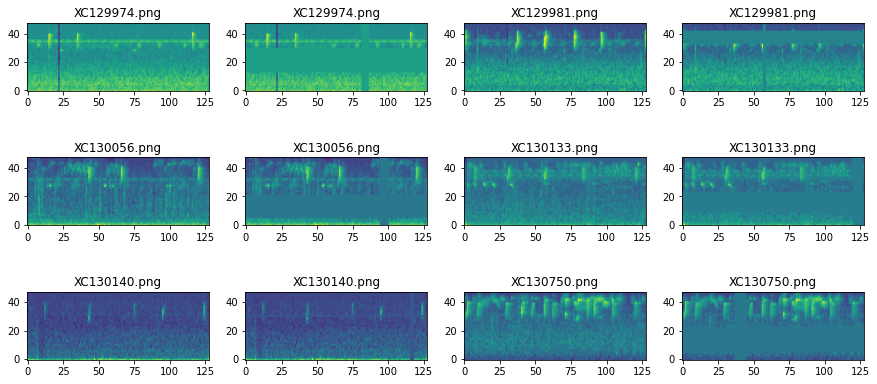

In [32]:
plt.figure(figsize=(15, 7))
for i in range(12):
    spec = Image.open(samples_df["song_sample"][i])
    plt.subplot(3, 4, i+1)
    plt.title(samples_df["song_sample"][i].split(os.sep)[-1])
    plt.imshow(spec, origin='lower')

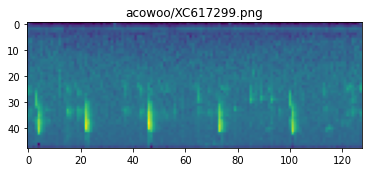

In [33]:
demo_img = Image.open('melspect_img/acafly/XC6671.png')
plt.imshow(demo_img)
plt.title('acowoo/XC617299.png')
plt.show()

In [34]:
# Shuffle data for training
shuffle_samples_df = shuffle(samples_df)

## 4. Model Creation and Training

### Training 1 (Using Augmented data)

#### Split Data into 80%, 10% and 10%

In [35]:
train_percent = 0.8
valid_percent = 0.1

length_sample_df = len(shuffle_samples_df)

train_end = int(train_percent * length_sample_df)
valid_end = int(valid_percent * length_sample_df) + train_end

train = shuffle_samples_df.iloc[:train_end]
validate = shuffle_samples_df.iloc[train_end:valid_end]

test = shuffle_samples_df.iloc[valid_end:]

print(train_end, valid_end)

58179 65451


In [36]:
classes_to_predict = sorted(shuffle_samples_df.label.unique())

#### Prepare Train, Valid and Test data

In [37]:
training_batch_size = 32
validation_batch_size = 32
test_batch_size = 32
target_size = (48,128)

train_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train,
    x_col='song_sample',
    y_col='label',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validate,
    x_col='song_sample',
    y_col='label',
    target_size=target_size,
    shuffle=True,
    batch_size=validation_batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    x_col='song_sample',
    y_col='label',
    target_size=target_size,
    batch_size=test_batch_size,
    shuffle=False,
    class_mode='categorical')

Found 58179 validated image filenames belonging to 200 classes.
Found 7272 validated image filenames belonging to 200 classes.
Found 7273 validated image filenames belonging to 200 classes.


In [83]:
# List of Primary Species name and their class id
test_generator.class_indices

{'acafly': 0,
 'acowoo': 1,
 'aldfly': 2,
 'amecro': 3,
 'amegfi': 4,
 'amered': 5,
 'amerob': 6,
 'andsol1': 7,
 'astfly': 8,
 'azaspi1': 9,
 'balori': 10,
 'banana': 11,
 'barant1': 12,
 'barswa': 13,
 'bawwar': 14,
 'baywre1': 15,
 'bbwduc': 16,
 'bcnher': 17,
 'belvir': 18,
 'bewwre': 19,
 'bkbplo': 20,
 'bkcchi': 21,
 'bkhgro': 22,
 'bkmtou1': 23,
 'bknsti': 24,
 'blbgra1': 25,
 'blhpar1': 26,
 'blkpho': 27,
 'blugrb1': 28,
 'blujay': 29,
 'bncfly': 30,
 'bnhcow': 31,
 'bobfly1': 32,
 'brbsol1': 33,
 'brncre': 34,
 'brnthr': 35,
 'brratt1': 36,
 'buggna': 37,
 'bugtan': 38,
 'buhvir': 39,
 'bulori': 40,
 'burwar1': 41,
 'bushti': 42,
 'butsal1': 43,
 'cacwre': 44,
 'cangoo': 45,
 'carchi': 46,
 'carwre': 47,
 'caskin': 48,
 'caster1': 49,
 'ccbfin': 50,
 'chbant1': 51,
 'chcant2': 52,
 'chispa': 53,
 'chswar': 54,
 'cinfly2': 55,
 'clcrob': 56,
 'cobtan1': 57,
 'coltro1': 58,
 'compau': 59,
 'comrav': 60,
 'comyel': 61,
 'cubthr': 62,
 'daejun': 63,
 'dowwoo': 64,
 'ducfly': 65,
 

#### Creation of CNN model

In [38]:
RANDOM_SEED = 1337
tf.random.set_seed(RANDOM_SEED)

model = tf.keras.Sequential([
    
    # First Convolutional -> BatchNormalization -> Maxpooling block
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
                           input_shape=(SPECT_SHAPE[0], SPECT_SHAPE[1], 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second Convolutional -> BatchNormalization -> Maxpooling block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third Convolutional -> BatchNormalization -> Maxpooling block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Fourth Convolutional -> BatchNormalization -> Maxpooling block
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Global Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),  
    tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(len(classes_to_predict), activation='softmax')
])

Metal device set to: Apple M1


2023-04-02 12:19:50.905854: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-02 12:19:50.906017: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [39]:
# Define F1Score function
f1_score=F1Score(num_classes=len(classes_to_predict),average='macro',name='f1_score')

In [40]:
# Define callbacks for training
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score', 
                                                  patience=2, 
                                                  verbose=1, 
                                                  mode='max',
                                                  factor=0.7),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              verbose=1,
                                              patience=10),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', 
                                                monitor='val_f1_score',
                                                mode='max',
                                                verbose=1,
                                                save_best_only=True)]

# Compile model and define loss function
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',f1_score])


In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 126, 16)       448       
                                                                 
 batch_normalization (BatchN  (None, 46, 126, 16)      64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 61, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 21, 61, 32)       128       
 hNormalization)                                                 
                                                        

In [42]:
from keras_sequential_ascii import keras2ascii
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     48  128    3
              Conv2D    \|/  -------------------       448     0.1%
                relu   #####     46  126   16
  BatchNormalization    μ|σ  -------------------        64     0.0%
                       #####     46  126   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     23   63   16
              Conv2D    \|/  -------------------      4640     1.0%
                relu   #####     21   61   32
  BatchNormalization    μ|σ  -------------------       128     0.0%
                       #####     21   61   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     10   30   32
              Conv2D    \|/  -------------------     36992     8.1%
                relu   #####      8   28  128
  BatchNormalization    μ|σ  -------------------       512     0.1%
              

In [43]:
# Function to plot accuracy and loss during training
def plot_history(history):
    his=pd.DataFrame(history.history)
    plt.subplots(1,2,figsize=(16,8))
    
    #loss:
    plt.subplot(1,2,1)
    plt.plot(range(len(his)),his['loss'],color='g',label='training')
    plt.plot(range(len(his)),his['val_loss'],color='r',label='validation')
    plt.legend()
    plt.title('Loss')
    
    #accuracy
    plt.subplot(1,2,2)
    plt.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
    plt.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')
    
    plt.legend()
    plt.title('accuracy')
    
    plt.show()

#### Model Training

In [44]:
history = model.fit(train_generator,
          epochs = 50, 
          validation_data=validation_generator,
          callbacks=callbacks)

Epoch 1/50


2023-04-02 12:19:55.052351: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-02 12:19:55.503056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1818/1819 [============================>.] - ETA: 0s - loss: 4.3303 - accuracy: 0.1092 - f1_score: 0.0778

2023-04-02 12:20:34.240983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_f1_score improved from -inf to 0.13570, saving model to best_model.h5
1819/1819 [==============================] - 42s 23ms/step - loss: 4.3297 - accuracy: 0.1094 - f1_score: 0.0778 - val_loss: 3.7916 - val_accuracy: 0.1884 - val_f1_score: 0.1357 - lr: 0.0010
Epoch 2/50
1819/1819 [==============================] - ETA: 0s - loss: 3.3082 - accuracy: 0.2613 - f1_score: 0.2212
Epoch 2: val_f1_score improved from 0.13570 to 0.27815, saving model to best_model.h5
1819/1819 [==============================] - 41s 23ms/step - loss: 3.3082 - accuracy: 0.2613 - f1_score: 0.2212 - val_loss: 3.0621 - val_accuracy: 0.3197 - val_f1_score: 0.2781 - lr: 0.0010
Epoch 3/50
1819/1819 [==============================] - ETA: 0s - loss: 2.8441 - accuracy: 0.3485 - f1_score: 0.3149
Epoch 3: val_f1_score improved from 0.27815 to 0.36375, saving model to best_model.h5
1819/1819 [==============================] - 41s 22ms/step - loss: 2.8441 - accuracy: 0.3485 - f1_score: 0.3149 - val_loss: 2.6487

Epoch 22/50
1819/1819 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.8463 - f1_score: 0.8412
Epoch 22: val_f1_score did not improve from 0.62820
1819/1819 [==============================] - 41s 23ms/step - loss: 0.5303 - accuracy: 0.8463 - f1_score: 0.8412 - val_loss: 1.8818 - val_accuracy: 0.6357 - val_f1_score: 0.6208 - lr: 3.4300e-04
Epoch 23/50
1818/1819 [============================>.] - ETA: 0s - loss: 0.5044 - accuracy: 0.8526 - f1_score: 0.8469
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.

Epoch 23: val_f1_score did not improve from 0.62820
1819/1819 [==============================] - 42s 23ms/step - loss: 0.5044 - accuracy: 0.8526 - f1_score: 0.8469 - val_loss: 1.9199 - val_accuracy: 0.6399 - val_f1_score: 0.6262 - lr: 3.4300e-04
Epoch 24/50
1819/1819 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8689 - f1_score: 0.8637
Epoch 24: val_f1_score did not improve from 0.62820
1819/1819 [============

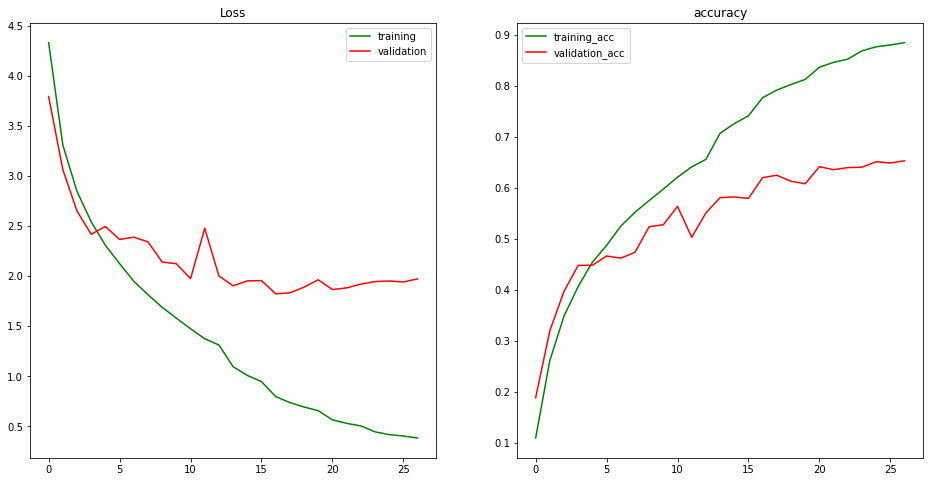

In [45]:
plot_history(history)

#### Prediction on test data (Unseen data)

In [47]:
preds = model.predict_generator(test_generator)
validation_df = pd.DataFrame(columns=["prediction", "groundtruth", "correct_prediction"])

for pred, groundtruth in zip(preds[:12], test_generator.__getitem__(0)[1]):
    validation_df = validation_df.append({"prediction":classes_to_predict[np.argmax(pred)], 
                                       "groundtruth":classes_to_predict[np.argmax(groundtruth)], 
                                       "correct_prediction":np.argmax(pred)==np.argmax(groundtruth)}, ignore_index=True)
validation_df
# validation_df.to_csv('Prediction with Augmentation')

,prediction,groundtruth,correct_prediction
0,fepowl,fepowl,True
1,eucdov,eucdov,True
2,whwdov,whwdov,True
3,eucdov,mallar3,False
4,tuftit,sumtan,False
5,houspa,houspa,True
6,ovenbi1,blujay,False
7,gbwwre1,veery,False
8,gwfgoo,gwfgoo,True
9,easmea,rucspa1,False


#### Evaluation of Model using Classification report

In [93]:
from sklearn.metrics import classification_report

# get the ground truth of your data. 
test_labels=test_generator.classes 

# predict the probability distribution of the data
predictions=model.predict_generator(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)
report_aug = classification_report(test_labels, y_pred, output_dict=True)
# get the classification report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.57      0.62        14
           1       0.70      0.59      0.64        32
           2       0.89      0.64      0.74        25
           3       0.70      0.68      0.69        38
           4       0.44      0.38      0.41        29
           5       0.62      0.69      0.66        36
           6       0.67      0.69      0.68        80
           7       0.59      0.66      0.62        35
           8       0.72      0.81      0.76        32
           9       0.76      0.71      0.73        48
          10       0.35      0.32      0.33        19
          11       0.54      0.65      0.59        43
          12       0.85      0.77      0.80        43
          13       0.61      0.74      0.67        89
          14       0.56      0.60      0.58        25
          15       0.50      0.35      0.41        23
          16       0.41      0.67      0.51        21
          17       0.62    

In [94]:
df_aug_class_report = pd.DataFrame(report_aug).transpose()

# Top 5 classes according to f1-score accuracy
df_aug_class_report[:200].sort_values(by = 'f1-score', ascending = False).head(5)

,precision,recall,f1-score,support
97,0.838710,0.962963,0.896552,27.0
192,0.888889,0.888889,0.888889,27.0
71,0.813953,0.897436,0.853659,39.0
189,0.825000,0.868421,0.846154,38.0
91,0.816667,0.875000,0.844828,56.0


### Training 2 (Without Augmentation)

In [49]:
samples_wo_aug_df = samples_df[::2]

In [50]:
samples_wo_aug_df = shuffle(samples_wo_aug_df)

#### Split Data into 80%, 10% and 10%

In [51]:
train_percent = 0.8
valid_percent = 0.1

length_sample_df = len(samples_wo_aug_df)

train_wo_aug_end = int(train_percent * length_sample_df)
valid_wo_aug_end = int(valid_percent * length_sample_df) + train_wo_aug_end

train_wo_aug = samples_wo_aug_df.iloc[:train_wo_aug_end]
validate_wo_aug = samples_wo_aug_df.iloc[train_wo_aug_end:valid_wo_aug_end]

test_wo_aug = samples_wo_aug_df.iloc[valid_wo_aug_end:]

print(train_wo_aug_end, valid_wo_aug_end)

29089 32725


In [52]:
classes_to_predict = sorted(samples_wo_aug_df.label.unique())

#### Prepare Train, Valid and Test data for training without augmentation

In [53]:
training_batch_size = 32
validation_batch_size = 32
test_batch_size = 32
target_size = (48,128)

train_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator1 = train_datagen.flow_from_dataframe(
    dataframe = train_wo_aug,
    x_col='song_sample',
    y_col='label',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator1 = validation_datagen.flow_from_dataframe(
    dataframe = validate_wo_aug,
    x_col='song_sample',
    y_col='label',
    target_size=target_size,
    shuffle=True,
    batch_size=validation_batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator1 = test_datagen.flow_from_dataframe(
    dataframe = test_wo_aug,
    x_col='song_sample',
    y_col='label',
    target_size=target_size,
    batch_size=test_batch_size,
    shuffle=False,
    class_mode='categorical')

Found 29089 validated image filenames belonging to 200 classes.
Found 3636 validated image filenames belonging to 200 classes.
Found 3637 validated image filenames belonging to 200 classes.


In [82]:
# List of Primary Species name and their class id
test_generator1.class_indices

{'acafly': 0,
 'acowoo': 1,
 'aldfly': 2,
 'amecro': 3,
 'amegfi': 4,
 'amered': 5,
 'amerob': 6,
 'andsol1': 7,
 'astfly': 8,
 'azaspi1': 9,
 'balori': 10,
 'banana': 11,
 'barant1': 12,
 'barswa': 13,
 'bawwar': 14,
 'baywre1': 15,
 'bbwduc': 16,
 'bcnher': 17,
 'belvir': 18,
 'bewwre': 19,
 'bkbplo': 20,
 'bkcchi': 21,
 'bkhgro': 22,
 'bkmtou1': 23,
 'bknsti': 24,
 'blbgra1': 25,
 'blhpar1': 26,
 'blkpho': 27,
 'blugrb1': 28,
 'blujay': 29,
 'bncfly': 30,
 'bnhcow': 31,
 'bobfly1': 32,
 'brbsol1': 33,
 'brncre': 34,
 'brnthr': 35,
 'brratt1': 36,
 'buggna': 37,
 'bugtan': 38,
 'buhvir': 39,
 'bulori': 40,
 'burwar1': 41,
 'bushti': 42,
 'butsal1': 43,
 'cacwre': 44,
 'cangoo': 45,
 'carchi': 46,
 'carwre': 47,
 'caskin': 48,
 'caster1': 49,
 'ccbfin': 50,
 'chbant1': 51,
 'chcant2': 52,
 'chispa': 53,
 'chswar': 54,
 'cinfly2': 55,
 'clcrob': 56,
 'cobtan1': 57,
 'coltro1': 58,
 'compau': 59,
 'comrav': 60,
 'comyel': 61,
 'cubthr': 62,
 'daejun': 63,
 'dowwoo': 64,
 'ducfly': 65,
 

#### Create same CNN model for training without augmented data

In [54]:
# Use the same model
RANDOM_SEED = 1337
tf.random.set_seed(RANDOM_SEED)

model1 = tf.keras.Sequential([
    
    # First Convolutional -> BatchNormalization -> Maxpooling block
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
                           input_shape=(SPECT_SHAPE[0], SPECT_SHAPE[1], 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second Convolutional -> BatchNormalization -> Maxpooling block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third Convolutional -> BatchNormalization -> Maxpooling block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Fourth Convolutional -> BatchNormalization -> Maxpooling block
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Global Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),  
    tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(len(classes_to_predict), activation='softmax')
])

In [55]:
f1_score=F1Score(num_classes=len(classes_to_predict),average='macro',name='f1_score')

In [56]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score', 
                                                  patience=2, 
                                                  verbose=1, 
                                                  mode='max',
                                                  factor=0.7),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              verbose=1,
                                              patience=10),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', 
                                                monitor='val_f1_score',
                                                mode='max',
                                                verbose=1,
                                                save_best_only=True)]

model1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',f1_score])


In [57]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 126, 16)       448       
                                                                 
 batch_normalization_4 (Batc  (None, 46, 126, 16)      64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 61, 32)        4640      
                                                                 
 batch_normalization_5 (Batc  (None, 21, 61, 32)       128       
 hNormalization)                                                 
                                                      

In [58]:
# Train model
history1 = model1.fit(train_generator1,
          epochs = 50, 
          validation_data=validation_generator1,
          callbacks=callbacks)

Epoch 1/50


2023-04-02 12:49:02.818996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


909/910 [============================>.] - ETA: 0s - loss: 4.4284 - accuracy: 0.0954 - f1_score: 0.0607

2023-04-02 12:49:24.590491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_f1_score improved from -inf to 0.12575, saving model to best_model.h5
910/910 [==============================] - 24s 25ms/step - loss: 4.4273 - accuracy: 0.0955 - f1_score: 0.0608 - val_loss: 3.7022 - val_accuracy: 0.1975 - val_f1_score: 0.1258 - lr: 0.0010
Epoch 2/50
908/910 [============================>.] - ETA: 0s - loss: 3.4107 - accuracy: 0.2351 - f1_score: 0.1868
Epoch 2: val_f1_score improved from 0.12575 to 0.21215, saving model to best_model.h5
910/910 [==============================] - 22s 24ms/step - loss: 3.4099 - accuracy: 0.2354 - f1_score: 0.1870 - val_loss: 3.3025 - val_accuracy: 0.2561 - val_f1_score: 0.2122 - lr: 0.0010
Epoch 3/50
908/910 [============================>.] - ETA: 0s - loss: 2.9013 - accuracy: 0.3299 - f1_score: 0.2866
Epoch 3: val_f1_score improved from 0.21215 to 0.28837, saving model to best_model.h5
910/910 [==============================] - 23s 25ms/step - loss: 2.9012 - accuracy: 0.3300 - f1_score: 0.2868 - val_loss: 2.9589 - val_acc

910/910 [==============================] - 23s 25ms/step - loss: 0.3630 - accuracy: 0.8892 - f1_score: 0.8823 - val_loss: 2.7702 - val_accuracy: 0.5418 - val_f1_score: 0.5106 - lr: 3.4300e-04
Epoch 23/50
910/910 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.9003 - f1_score: 0.8939
Epoch 23: val_f1_score did not improve from 0.51058
910/910 [==============================] - 21s 23ms/step - loss: 0.3255 - accuracy: 0.9003 - f1_score: 0.8939 - val_loss: 2.7641 - val_accuracy: 0.5404 - val_f1_score: 0.5099 - lr: 3.4300e-04
Epoch 23: early stopping


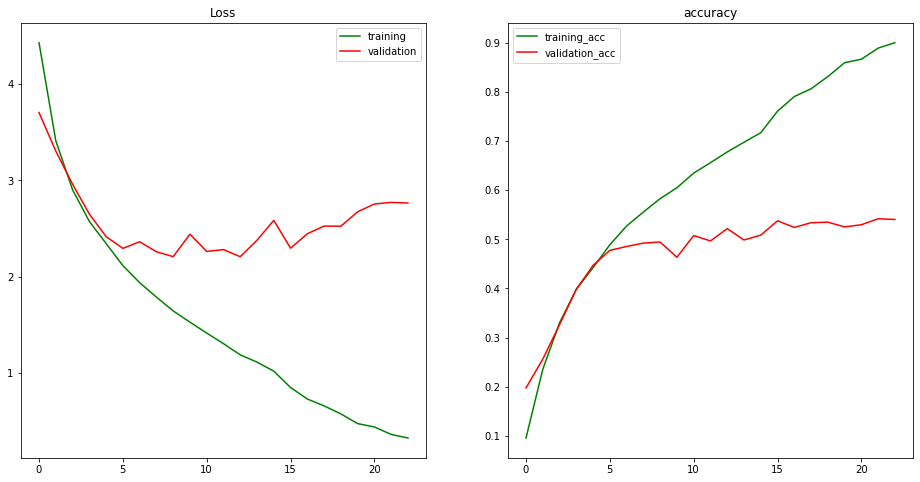

In [59]:
# Plot loss and accuracy graph
plot_history(history1)

In [61]:
preds1 = model1.predict_generator(test_generator1)
validation_wo_aug_df = pd.DataFrame(columns=["prediction", "groundtruth", "correct_prediction"])

for pred, groundtruth in zip(preds1[:12], test_generator1.__getitem__(0)[1]):
    validation_wo_aug_df = validation_wo_aug_df.append({"prediction":classes_to_predict[np.argmax(pred)], 
                                       "groundtruth":classes_to_predict[np.argmax(groundtruth)], 
                                       "correct_prediction":np.argmax(pred)==np.argmax(groundtruth)}, ignore_index=True)

validation_wo_aug_df
# validation_wo_aug_df.to_csv('Prediction with Augmentation')

,prediction,groundtruth,correct_prediction
0,foxspa,foxspa,True
1,savspa,savspa,True
2,banana,amered,False
3,yeofly1,orbeup1,False
4,whwbec1,whwbec1,True
5,acowoo,acowoo,True
6,grethr1,grethr1,True
7,bcnher,bcnher,True
8,savspa,sonspa,False
9,coltro1,grasal1,False


In [66]:
from sklearn.metrics import classification_report

# get the ground truth of your data. 
test_labels=test_generator1.classes 

# predict the probability distribution of the data
predictions1=model1.predict_generator(test_generator1)

# get the class with highest probability for each sample
y_pred1 = np.argmax(predictions1, axis=-1)
report = classification_report(test_labels, y_pred1, output_dict=True)
# get the classification report
print(classification_report(test_labels, y_pred1))

              precision    recall  f1-score   support

           0       0.44      0.40      0.42        10
           1       0.58      0.65      0.61        17
           2       0.67      0.60      0.63        10
           3       0.67      0.80      0.73        20
           4       0.12      0.08      0.10        12
           5       0.65      0.62      0.63        21
           6       0.38      0.39      0.38        23
           7       0.42      0.50      0.46        16
           8       0.42      0.71      0.53        14
           9       0.50      0.65      0.56        17
          10       0.09      0.17      0.12         6
          11       0.27      0.41      0.33        22
          12       0.56      0.38      0.45        13
          13       0.47      0.75      0.58        44
          14       0.88      0.50      0.64        14
          15       0.31      0.27      0.29        15
          16       0.40      0.18      0.25        11
          17       0.50    

In [67]:
df_class_report = pd.DataFrame(report).transpose()

In [77]:
# Top 5 classes according to f1-score accuracy
df_class_report[:200].sort_values(by = 'f1-score', ascending = False).head(5)

,precision,recall,f1-score,support
23,1.000000,1.000000,1.000000,15.0
156,0.857143,0.947368,0.900000,19.0
97,0.785714,1.000000,0.880000,11.0
71,0.875000,0.875000,0.875000,24.0
52,0.916667,0.785714,0.846154,14.0
